In [1]:
import cptac
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics
import parse_correlations_dataframe as get_corr
import copy

cptac warning: Your version of cptac (0.8.6) is out-of-date. Latest is 0.8.8. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-147bbc873c03>, line 1)


In [2]:
cptac.download("endometrial")
en = cptac.Endometrial()

In [3]:
def find_mut_tumor(cancer_type, gene):
    try:
        gene_multi = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene, 'somatic_mutation': gene}, tissue_type = 'tumor', flatten = True)
        normal = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene}, tissue_type= 'normal', flatten = True)
        normal.columns = ['proteomics', 'transcriptomics']
        gene_multi.columns = ['proteomics', 'transcriptomics', 'mutation', 'location', 'mutation_status']
        trans = list(gene_multi["transcriptomics"])
        prot = list(gene_multi['proteomics'])
        group = []
        for i in gene_multi['mutation_status']:
            if type(i) == str:
                group.append("mutation")
            else:
                group.append("wt") 
        if group.count('wt') < 2 or len(normal) < 2:
            return float("NaN")
        group.extend(['normal']*len(normal))
        prot.extend(list(normal['proteomics']))
        trans.extend(list(normal['transcriptomics']))
        gene_df = pd.DataFrame({'Type': group, 'Proteomics': prot, 'Transcriptomics': trans})
        gene_df = gene_df.dropna()
        return gene_df
    except:
        return float("NaN")
   

In [4]:
def get_df_with_type(df,input_type):
    return(df.loc[df['Type']==input_type])

In [5]:
# https://link.springer.com/article/10.3758/s13428-012-0289-7
def compare_correlations(r1, r2, n1, n2):
    rp1 = np.arctanh(r1)
    rp2 = np.arctanh(r2)
    Sr12 = sqrt ((1/n1-3)+(1/n2-3))
    z = (rp1-rp2) / Sr12
    

In [6]:
df = find_mut_tumor(en, 'TP53')

cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)


In [7]:
df

,Type,Proteomics,Transcriptomics
0,mutation,0.2950,11.62
1,wt,0.2770,11.83
2,wt,-0.8710,10.73
3,wt,-0.3430,10.95
4,mutation,3.0100,10.69
...,...,...,...
115,normal,0.7950,9.83
116,normal,0.6270,10.64
119,normal,-0.2370,9.62
120,normal,-0.7290,10.45


In [8]:
df2 = get_df_with_type(df,"normal")

In [9]:
df2

,Type,Proteomics,Transcriptomics
95,normal,-0.0919,9.87
96,normal,-0.5930,10.52
98,normal,-0.1310,9.98
99,normal,-0.0844,9.92
113,normal,0.5140,10.35
114,normal,0.2500,10.27
115,normal,0.7950,9.83
116,normal,0.6270,10.64
119,normal,-0.2370,9.62
120,normal,-0.7290,10.45


In [10]:
df2.corr(method="pearson")

,Proteomics,Transcriptomics
Proteomics,1.000000,-0.045068
Transcriptomics,-0.045068,1.000000


In [11]:
df2.corr(method="pearson")['Transcriptomics'][0]

-0.04506791545565061

In [12]:
df3 = df[df['Type'] != 'mutation']

In [18]:
def get_cancer_string(cancer):

    if cancer == ccrcc:
        return "ccrcc"

    if cancer == en:
        return 'en'

    if cancer == luad:
        return 'luad'

    if cancer == hnscc:
        return 'hnscc'
    if cancer == lscc:
        return 'lscc'

In [14]:

ccrcc = cptac.Ccrcc()

en = cptac.Endometrial()

luad = cptac.Luad()

hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-14-06ef7d383b39>, line 7)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-14-06ef7d383b39>, line 8)


In [15]:
cancer_genes = ['TP53','BRCA2','KMT2D','KRAS','PIK3CA','PTEN']
cancer_list = [ccrcc,en,luad,hnscc,lscc]

In [19]:
cancer_type = []
genes = []
gene_dfs = []
norm_corr = []
wt_corr = []
for cancer in cancer_list:
    for gene in cancer_genes:
        if gene == 'KRAS' and cancer == ccrcc:
            continue
        df = find_mut_tumor(cancer, gene)
        if type(df) == pd.DataFrame:
            genes.append(gene)
            cancer_type.append(get_cancer_string(cancer))
            gene_dfs.append(df)
            norm_df = get_df_with_type(df,"normal")
            wt_df = get_df_with_type(df, 'wt')
            norm_cor = norm_df.corr(method="pearson")['Transcriptomics'][0]
            wt_cor = wt_df.corr(method="pearson")['Transcriptomics'][0]
            norm_corr.append(norm_cor)
            wt_corr.append(wt_cor)
norm_vs_wt_tumor = pd.DataFrame({'cancer': cancer_type, 'gene': genes, 'gene_df': gene_dfs,'normal_correlation': norm_corr, 'tumor_non-mutated_correlation': wt_corr})
norm_vs_wt_tumor.head()           


cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: BRCA2 (<ipython-input-3-d98f306443a4>, line 3)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: BRCA2 (<ipython-input-3-d98f306443a4>, line 4)
cptac warning: You tried to flat

,cancer,gene,gene_df,normal_correlation,tumor_non-mutated_correlation
0,ccrcc,TP53,Type Proteomics Transcriptomics 2 ...,-0.278706,0.092992
1,ccrcc,BRCA2,Type Proteomics Transcriptomics 2 ...,-0.662538,-0.341958
2,ccrcc,KMT2D,Type Proteomics Transcriptomics 0 ...,-0.071417,0.077649
3,ccrcc,PIK3CA,Type Proteomics Transcriptomics 0 ...,0.199898,0.511689
4,ccrcc,PTEN,Type Proteomics Transcriptomics 0 ...,0.649130,0.471577


In [20]:
norm_vs_wt_tumor = norm_vs_wt_tumor.assign(corr_dif = abs(norm_vs_wt_tumor['normal_correlation'] - norm_vs_wt_tumor['tumor_non-mutated_correlation']))
norm_vs_wt_tumor.head()

,cancer,gene,gene_df,normal_correlation,tumor_non-mutated_correlation,corr_dif
0,ccrcc,TP53,Type Proteomics Transcriptomics 2 ...,-0.278706,0.092992,0.371698
1,ccrcc,BRCA2,Type Proteomics Transcriptomics 2 ...,-0.662538,-0.341958,0.320580
2,ccrcc,KMT2D,Type Proteomics Transcriptomics 0 ...,-0.071417,0.077649,0.149065
3,ccrcc,PIK3CA,Type Proteomics Transcriptomics 0 ...,0.199898,0.511689,0.311791
4,ccrcc,PTEN,Type Proteomics Transcriptomics 0 ...,0.649130,0.471577,0.177553


In [21]:
norm_vs_wt_tumor = norm_vs_wt_tumor.sort_values(by = 'corr_dif', ascending=False, ignore_index=True)
norm_vs_wt_tumor.head()

,cancer,gene,gene_df,normal_correlation,tumor_non-mutated_correlation,corr_dif
0,lscc,TP53,Type Proteomics Transcriptomics 0 ...,-0.344411,0.800819,1.145229
1,hnscc,PIK3CA,Type Proteomics Transcriptomics 0 ...,0.028087,0.810448,0.782362
2,hnscc,PTEN,Type Proteomics Transcriptomics 0 ...,-0.073318,0.634816,0.708134
3,lscc,PTEN,Type Proteomics Transcriptomics 0 ...,0.054532,0.708334,0.653802
4,en,KMT2D,Type Proteomics Transcriptomics 0 ...,-0.272880,0.304781,0.577661


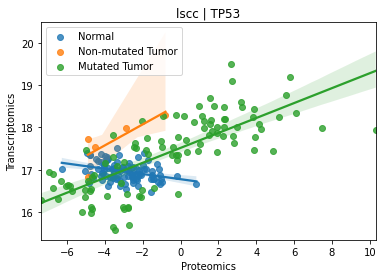

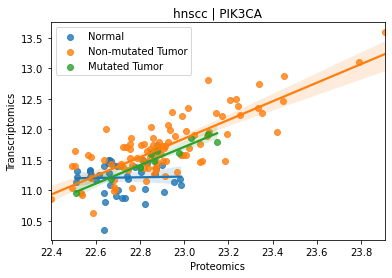

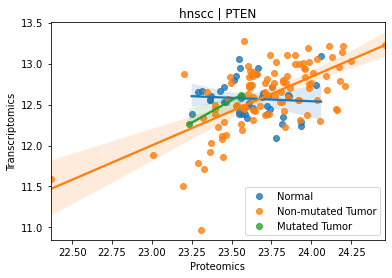

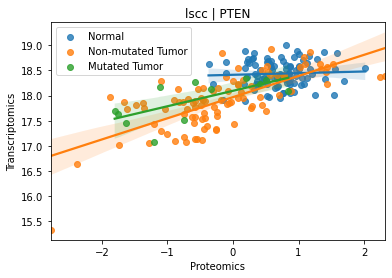

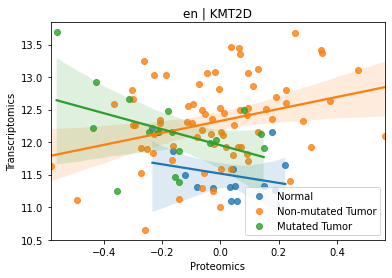

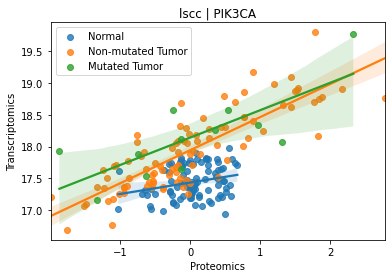

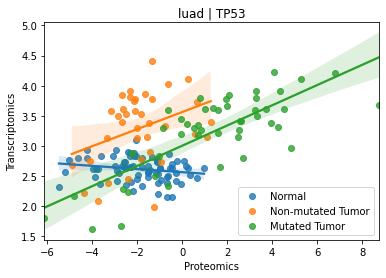

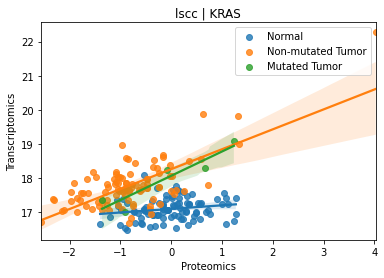

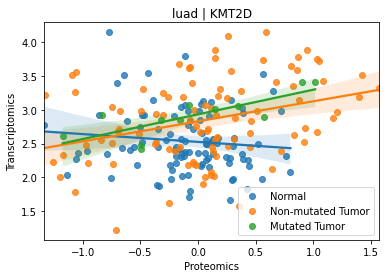

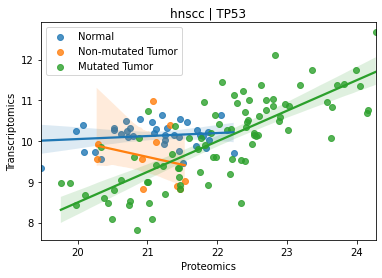

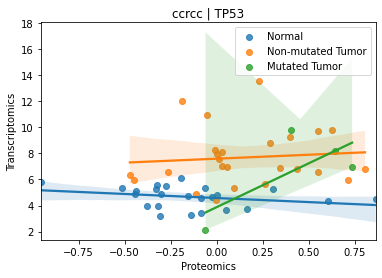

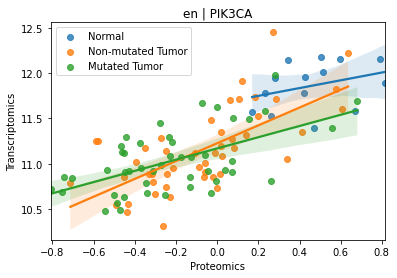

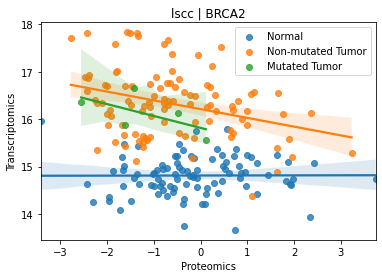

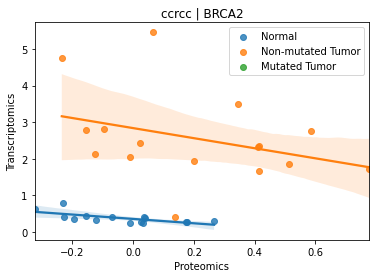

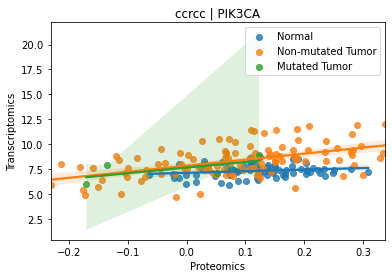

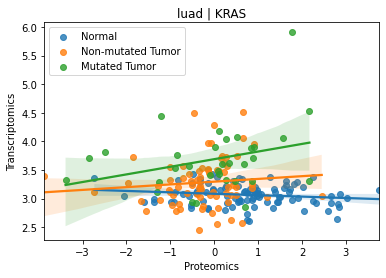

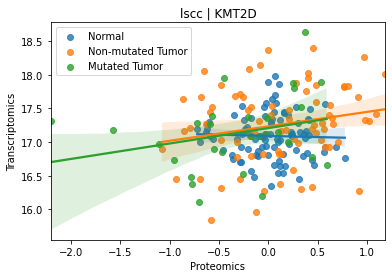

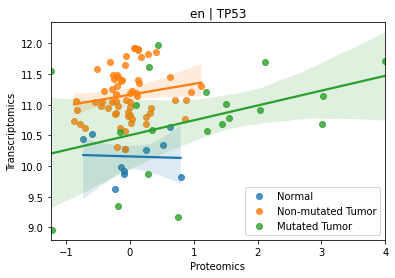

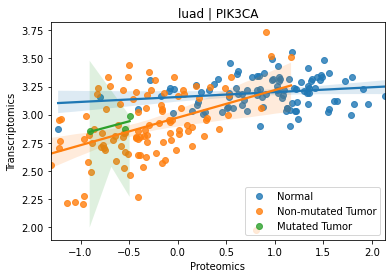

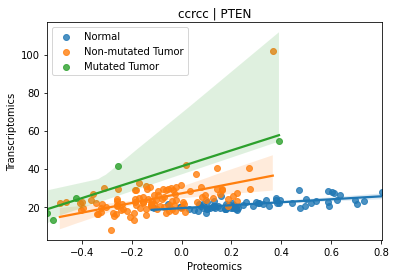

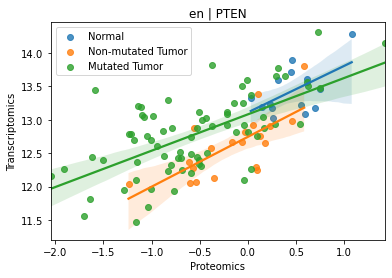

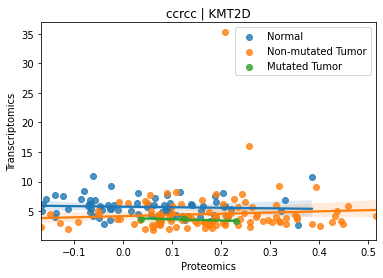

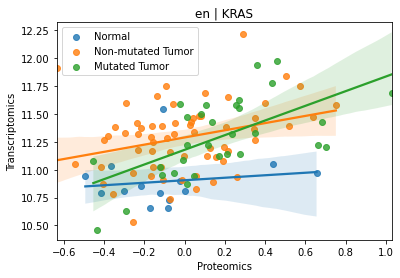

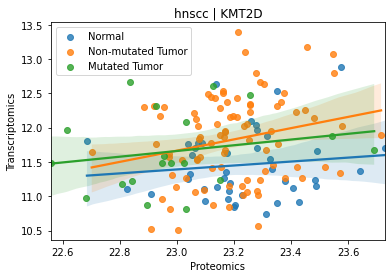

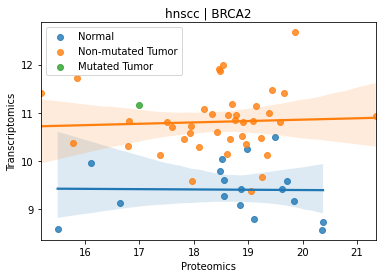

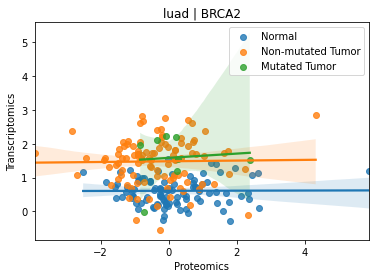

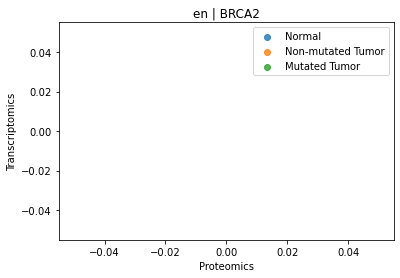

<Figure size 432x288 with 0 Axes>

In [24]:
for index, df in enumerate(norm_vs_wt_tumor['gene_df']):
    
    is_norm = df['Type']=='normal'
    is_tum = df['Type'] == 'wt'
    is_mut = df['Type'] == 'mutation'
    ax = sns.regplot(x = 'Proteomics', y = 'Transcriptomics', data = df[is_norm], label = "Normal")
    ax = sns.regplot(x = 'Proteomics', y = 'Transcriptomics', data = df[is_tum], label = 'Non-mutated Tumor')
    ax = sns.regplot(x = 'Proteomics', y = 'Transcriptomics', data = df[is_mut], label = 'Mutated Tumor')
    ax.legend(loc = 'best')
    plt.title(str(norm_vs_wt_tumor['cancer'][index] + ' | ' + norm_vs_wt_tumor['gene'][index]))
    plt.show()
    plt.savefig(str('Normal_vs_tumor_vs_mutant_plots/' + norm_vs_wt_tumor['cancer'][index] + '_' + norm_vs_wt_tumor['gene'][index] + '.png'))